In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/animal-image-datasetdog-cat-and-panda/animals/animals/dogs/dogs_00583.jpg
/kaggle/input/animal-image-datasetdog-cat-and-panda/animals/animals/dogs/dogs_00683.jpg
/kaggle/input/animal-image-datasetdog-cat-and-panda/animals/animals/dogs/dogs_00750.jpg
/kaggle/input/animal-image-datasetdog-cat-and-panda/animals/animals/dogs/dogs_00652.jpg
/kaggle/input/animal-image-datasetdog-cat-and-panda/animals/animals/dogs/dogs_00895.jpg
/kaggle/input/animal-image-datasetdog-cat-and-panda/animals/animals/dogs/dogs_00686.jpg
/kaggle/input/animal-image-datasetdog-cat-and-panda/animals/animals/dogs/dogs_00622.jpg
/kaggle/input/animal-image-datasetdog-cat-and-panda/animals/animals/dogs/dogs_00291.jpg
/kaggle/input/animal-image-datasetdog-cat-and-panda/animals/animals/dogs/dogs_00944.jpg
/kaggle/input/animal-image-datasetdog-cat-and-panda/animals/animals/dogs/dogs_00082.jpg
/kaggle/input/animal-image-datasetdog-cat-and-panda/animals/animals/dogs/dogs_00955.jpg
/kaggle/input/animal-image-datas

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import InceptionV3

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
base_model = InceptionV3(input_shape=(150,150,3),weights='imagenet', include_top=False)

87910968/87910968 [==============================] - 1s 0us/step


In [7]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

In [8]:
from tensorflow.keras.models import Model
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False

In [9]:
data = '/kaggle/input/animal-image-datasetdog-cat-and-panda/animals/animals'

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data generator untuk data latih dengan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

# Data generator untuk data validasi tanpa augmentasi
validation_datagen = ImageDataGenerator(rescale=1./255,
                                        validation_split=0.2)  # Data validasi tidak perlu augmentasi




# Buat generator data latih
train_generator = train_datagen.flow_from_directory(
    data,  # direktori data latih
    target_size=(150, 150),
    shuffle=True,
    class_mode='categorical',
    subset='training')

# Buat generator data validasi
validation_generator = validation_datagen.flow_from_directory(
    data,  # direktori data validasi
    target_size=(150, 150),
    class_mode='categorical',
    subset='validation')

# Kemudian Anda dapat menggunakan generator ini dalam model Anda

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [11]:
print("Kelas dari train_generator:")
print(train_generator.class_indices)

# Mencetak kelas dari validation_generator
print("Kelas dari validation_generator:")
print(validation_generator.class_indices)

Kelas dari train_generator:
{'cats': 0, 'dogs': 1, 'panda': 2}
Kelas dari validation_generator:
{'cats': 0, 'dogs': 1, 'panda': 2}


In [12]:
class_names = train_generator.class_indices
print(class_names)

{'cats': 0, 'dogs': 1, 'panda': 2}


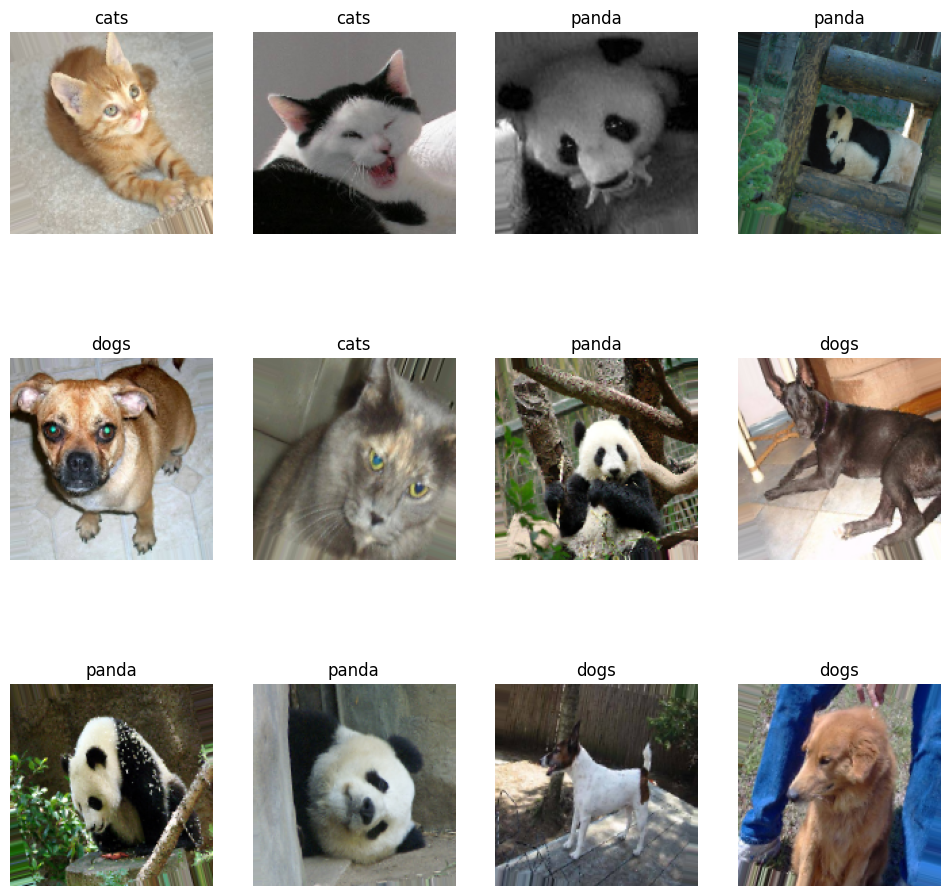

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))

# Mengambil satu batch gambar dari train_generator
images, labels = next(train_generator)
for i in range(12):  # Mengambil 12 gambar dari batch
    ax = plt.subplot(3, 4, i + 1)  # Menggunakan grid 3x4 untuk 12 gambar
    plt.imshow(images[i])
    class_index = labels[i].argmax()  # Mengambil indeks kelas dari one-hot encoding
    class_name = list(train_generator.class_indices.keys())[class_index]
    plt.title(class_name)
    plt.axis("off")

plt.show()

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [21]:
class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if (logs.get('accuracy') > 0.98 and logs.get('val_accuracy') > 0.97):
                print("\n Accuracy telah mencapai 97% atau lebih, menghentikan pelatihan ")
                self.model.stop_training = True

callback = myCallback()

In [22]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [23]:
history = model.fit(
          train_generator,
          epochs=50,
          steps_per_epoch=64,
          validation_data=validation_generator, 
          validation_steps=5,  
          verbose=2,
          callbacks=[callback])

Epoch 1/50
64/64 - 24s - loss: 0.1278 - accuracy: 0.9575 - val_loss: 0.3406 - val_accuracy: 0.9187 - 24s/epoch - 371ms/step
Epoch 2/50
64/64 - 17s - loss: 0.1294 - accuracy: 0.9639 - val_loss: 0.2123 - val_accuracy: 0.9500 - 17s/epoch - 264ms/step
Epoch 3/50
64/64 - 17s - loss: 0.0645 - accuracy: 0.9780 - val_loss: 0.1851 - val_accuracy: 0.9563 - 17s/epoch - 269ms/step
Epoch 4/50
64/64 - 16s - loss: 0.0944 - accuracy: 0.9692 - val_loss: 0.1412 - val_accuracy: 0.9688 - 16s/epoch - 257ms/step
Epoch 5/50
64/64 - 17s - loss: 0.0728 - accuracy: 0.9751 - val_loss: 0.2697 - val_accuracy: 0.9250 - 17s/epoch - 260ms/step
Epoch 6/50
64/64 - 17s - loss: 0.0362 - accuracy: 0.9883 - val_loss: 0.1635 - val_accuracy: 0.9563 - 17s/epoch - 258ms/step
Epoch 7/50
64/64 - 17s - loss: 0.0497 - accuracy: 0.9814 - val_loss: 0.2240 - val_accuracy: 0.9500 - 17s/epoch - 265ms/step
Epoch 8/50

 Accuracy telah mencapai 97% atau lebih, menghentikan pelatihan 
64/64 - 17s - loss: 0.0446 - accuracy: 0.9824 - val_los

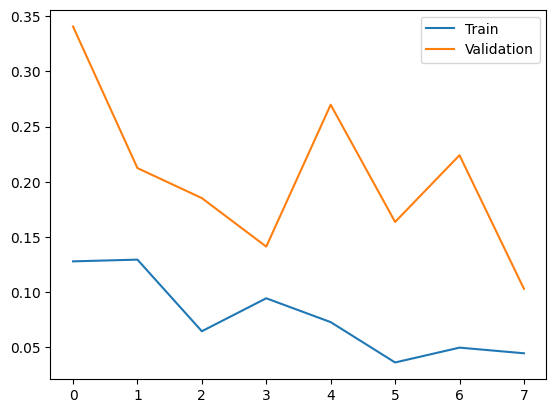

In [24]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],label='Train')
plt.plot(history.history['val_loss'],label='Validation')
plt.legend()

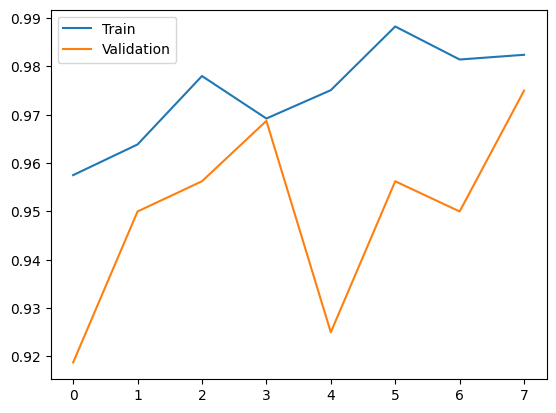

In [25]:
plt.plot(history.history['accuracy'],label='Train')
plt.plot(history.history['val_accuracy'],label='Validation')
plt.legend()

In [26]:
#78 acc dan 70 val_acc
#68 dan 62
#78 dan 73